## This original notebook ended up functioning as a dump for test cells and nolonger useful code. Can be largely ignorned.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
import pysynphot as S
import pandas as pd
%matplotlib inline

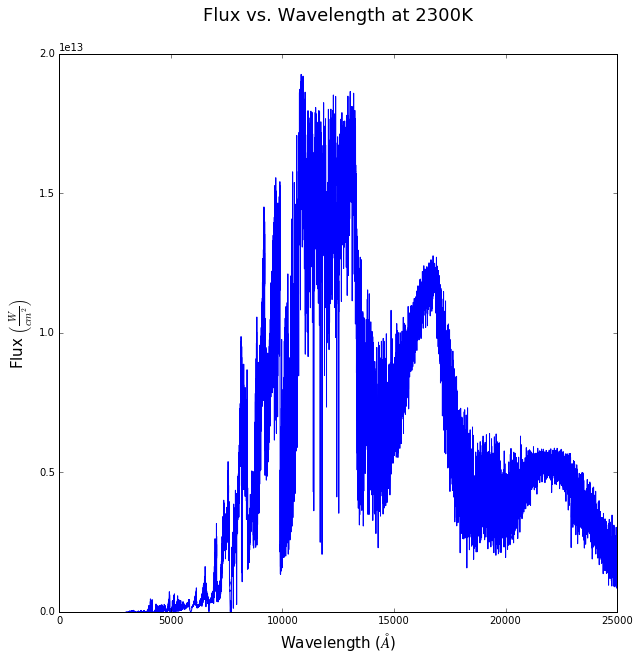

In [15]:
def get_model( temp ):
    '''
    Function opens Phoenix file of specified temperature in 100 Kelvin increments from 2300 to 12000 Kelvin.
    Parameters
    ----------
    temp: str
        Desired temperature in 100K increments from 2300 to 12,000 Kelvin
        
    Returns
    -------
    wavelength: array
        Associated wavelengths for flux measurements from Phoenix FITS file, in Angstroms
        
    flux: array
        Flux measurements from Phoenix FITS file, in erg/s/cm^2
        
    temp: str
        See Parameters
    '''
    model_file = 'PHOENIX-ACES-AGSS-COND-2011_R10000FITS_Z-0.0/lte0' + temp + '-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
    hdulist = fits.open(model_file)
    flux = hdulist[0].data
    wavelength = np.exp(hdulist[0].header[('CRVAL1')]+hdulist[0].header[('CDELT1')]*np.arange(0,212027))
    return wavelength, flux, temp, hdulist

#User inputs temperature; wavelength, flux and temp are filled with data
wavelength, flux, temp, hdulist = get_model('2300')

plt.figure(figsize=(10,10))
plt.plot(wavelength,flux)
plt.title('Flux vs. Wavelength at ' + temp + 'K',fontsize=18,y=1.05)
plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel(r'Flux $\left(\frac{W}{cm^2}\right)$', fontsize=15)

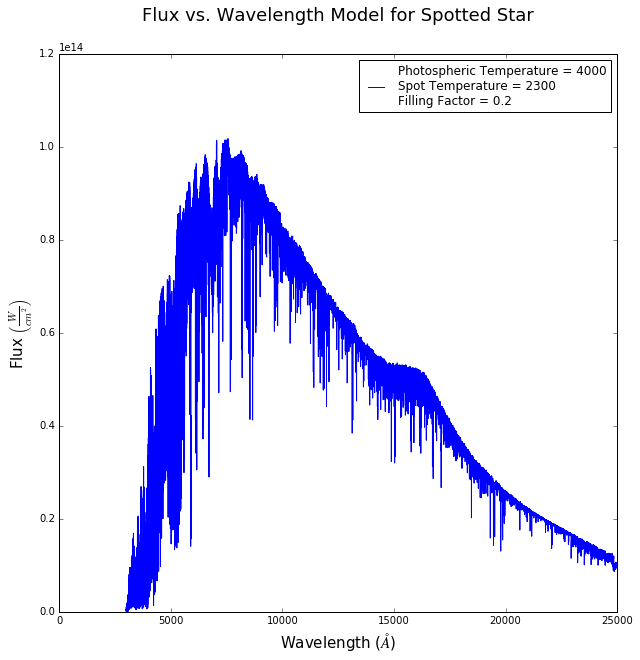

In [8]:
#Function will combine spectra of two temperature models plus filling factor to model starspots
def make_spotmodel( PhTemp, SpTemp, FillFactor ):
    '''
    Funtion models a spotted star through the get_model function by adding two different temperatured spectra
    and combining with a certain filling factor.
    Parameters
    ----------
    PhTemp: str
        Desired photospheric temperature of the star, in 100 Kelvin increments from 2300 to 12,000
    
    SpTemp: str
        Desired temperature of spot, same scale as PhTemp
    
    FillFactor: str
        Fraction of the star's surface covered by spot, decimal from 0 to 1
        
    Returns
    -------
    wavelength: array
        Corresponding wavelengths of spectral data, units of Angstroms
    
    tot_flux: array
        Combined fluxes of the photospheric and spot spectra, units of ergs/s/cm^2
    
    PhTemp, SpTemp, FillFactor: str
        Input values
    '''
    tot_flux = (1-FillFactor)*get_model( PhTemp )[1] + FillFactor*get_model( SpTemp )[1]
    return wavelength, tot_flux, PhTemp, SpTemp, FillFactor

#User inputs parameters
spotmodelwavl, spotmodelfl, PhTemp, SpTemp, FillFactor = make_spotmodel('4000','2300',0.2)

plt.figure(figsize=(10,10))
plt.plot(spotmodelwavl, spotmodelfl)
plt.title('Flux vs. Wavelength Model for Spotted Star',fontsize=18,y=1.05)
plt.xlabel('Wavelength ($\AA$)',fontsize=15)

#How to remove blue line from legend/move it outside plot
plt.legend(['Photospheric Temperature = ' + PhTemp + '\nSpot Temperature = ' + SpTemp +'\nFilling Factor = ' + str(FillFactor)],loc=0)
plt.ylabel(r'Flux $\left(\frac{W}{cm^2}\right)$',fontsize=15)
plt.savefig('spotfig.png')

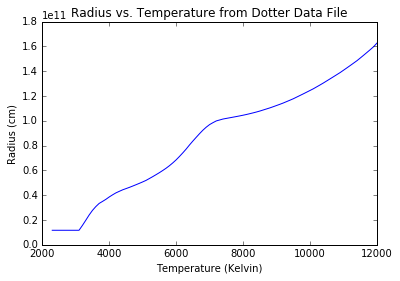

In [9]:
#Creating a method of finding stellar radius based on the input temperature from the Dotter Data. Note stellar age = log(8.1)
#Problem may occur however when reordering the data into ascending temperatures/radii. Data needs to be ascending for np.interp,
#but right now 'Temperatures' and 'Radii' data are not read as pairs, how to make a tuple of Temp/Radii?
#  ^^^ Above problems solved! ^^^

DotterData = open('models/Dotter_2014_isochrones','r')        #Opening the Dotter Data file and creating a readable table
names = DotterData.readline().split
DotterData.close()
DotterData = pd.read_table('models/Dotter_2014_isochrones', sep=r'\s+', engine='python')


DotterData['logAge']                                              #Look at the list of logAge data
Age_idx = np.where(DotterData['logAge']==8.1)                       #Create an index for the data where logAge = 8.1
TempData = 10**DotterData['logTeff'].values[Age_idx]              #Create array of temperature data, on absolute scale
RadData = 69.63*(10**9)*10**DotterData['logR_Ro'].values[Age_idx] #Create an array of radius data, on absolute scale, no ratio
Data = list(zip(TempData,RadData))                                #Combine the temp and rad data into a tuple array so temp and rad
                                                                  #don't become miss-ordered
def getKey(item):
    return item[0]
SortedData = sorted(Data, key=getKey)                         #Sort the tuple array by ascending temperature

del SortedData[12]                                            #Remove the red giant data point

Temperaturesx = np.arange(2300,12100,100).tolist()            #Creating final lists for calculations
StrTemperaturesx = [str(i) for i in Temperaturesx]

Radiiy = np.interp(Temperaturesx,[i[0] for i in SortedData], [i[1] for i in SortedData])



plt.plot(Temperaturesx, Radiiy)
plt.title('Radius vs. Temperature from Dotter Data File')
plt.xlabel('Temperature (Kelvin)')
plt.ylabel('Radius (cm)')

#----Now the temperature vs radius data is in a smooth curve with correct units (Kelvin, cm) :D
#----for the upcoming flux conversion. <3 <3



#CONSIDER CREATING A FUNCTION OUT OF THIS CELL IN HELP FILE
#Could maybe use some variable cleanup later

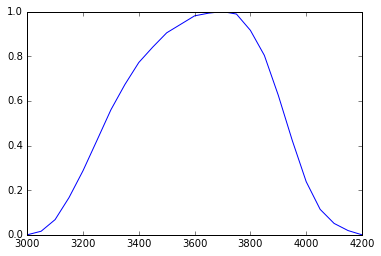

In [4]:
bandwav,bandpass=np.loadtxt('filters/bessell_U.dat',unpack=True)
plt.plot(bandwav,bandpass)

In [ ]:
PhRange = np.arange(7000,3000,-200)
PhRange = [str(i) for i in PhRange]
SpRange = np.arange(7000,3000,-200)
SpRange = [str(i) for i in SpRange]
FillFactor = 0

FluxRange = []
for i in range(len(PhRange)):
    wavelength,flux_Phoenix,PhTemp,SpTemp,FillFactor = make_spotmodel(PhRange[i],SpRange[i],FillFactor)
    Flux = Dotter_rad( PhTemp, flux_Phoenix )
    FluxRange.append(Flux)

Vmags = []
for i in range(len(FluxRange)):
    band,center,mag = getMag_hires('V',wavelength,FluxRange[i],'microns')
    Vmags.append(mag)

Kmags = []
for i in range(len(FluxRange)):
    band,center,mag = getMag_hires('Ks',wavelength,FluxRange[i],'microns')
    Kmags.append(mag)

print(Vmags)
print(Kmags)

VKmags = [i-j for i,j in zip(Vmags,Kmags)]

plt.plot(VKmags,Vmags)
plt.gca().invert_yaxis()
plt.xlabel('V-K Magnitude')
plt.ylabel('V Magnitude')

In [ ]:
PhRange = np.arange(7000,3000,-200)
PhRange = [str(i) for i in PhRange]
SpRange = np.arange(7000,3000,-200)
SpRange = [str(int(round(0.75*i/100)*100)) for i in SpRange]
FillFactor = 0.3
print(SpRange)

FluxRange = []
for i in range(len(PhRange)):
    wavelength,flux_Phoenix,PhTemp,SpTemp,FillFactor = make_spotmodel(PhRange[i],SpRange[i],FillFactor)
    Flux = Dotter_rad( PhTemp, flux_Phoenix )
    FluxRange.append(Flux)



Vmags = []
for i in range(len(FluxRange)):
    band,center,mag = getMag_hires('V',wavelength,FluxRange[i],'microns')
    Vmags.append(mag)

Kmags = []
for i in range(len(FluxRange)):
    band,center,mag = getMag_hires('Ks',wavelength,FluxRange[i],'microns')
    Kmags.append(mag)

print(Vmags)
print(type(Kmags))

VKmags = [i-j for i,j in zip(Vmags,Kmags)]

plt.plot(VKmags,Vmags)
plt.gca().invert_yaxis()
plt.xlabel('V-K Magnitude')
plt.ylabel('V Magnitude')

In [12]:
#THINGS BELOW THIS CELL ARE NOT STRICTLY RELEVANT











#:)

In [ ]:
bandwav,bandpass=np.loadtxt('filters/k_filter.txt',unpack=True)
bandwav = [i/1.0E4 for i in bandwav]
plt.plot(bandwav,bandpass,'ro')
plt.savefig('k_filter.jpg')

In [ ]:
#Edit: Dr.Larson's code takes care of this nicely

#This seems to be the way I'll want to create the wavelength and flux arrays for use in Dr. Larson's code.
#At some point I will make a new "official" notebook where the main structure of the code is.
    #Plus another notebook which will house the 'get_model' and 'spot_model' functions.

newflux = np.interp(np.linspace(0,25000,212027),wavelength,flux)
newwave = np.linspace(0,25000,212027)
plt.plot(newwave,newflux)

In [ ]:
print (wavelength[1]-wavelength[0])
print (wavelength[1000]-wavelength[999])
print (wavelength[-1])
print (wavelength.size)
newflux = np.interp(np.linspace(0,25000,212027),wavelength,flux)
newwave = np.linspace(0,25000,212027)
plt.plot(newwave,newflux)

In [ ]:
'''kep_bp = S.FileBandpass('./filters/kep_filter.txt')
spec = S.spectrum.ArraySourceSpectrum(wave=wavelength,flux=flux)
#plt.plot(spec.wave,spec.flux)
#plt.plot(bp.wave, bp.throughput)
#plt.yscale("log")
#kep_bp.obsmode.bandWave()
obs = S.Observation(spec, kep_bp)
#print (spec.wave)
#plt.plot(spec.wave,obs)'''

In [16]:
hdulist.info()

Filename: PHOENIX-ACES-AGSS-COND-2011_R10000FITS_Z-0.0/lte02300-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      27   (212027,)    float32   


In [17]:
wavelength.shape
#hdulist[0].shape

(212027,)

In [18]:
hdulist[0].data.shape

(212027,)

In [19]:
hdulist[0].header[('CRVAL1')]

8.006368

In [20]:
hdulist[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    1 / number of data axes                            
NAXIS1  =               212027 / length of data axis 1                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CRVAL1  =             8.006368                                                  
CDELT1  =              1.0E-05                                                  
CTYPE1  = 'AWAV-LOG'                                                            
PHXTEFF =               2300.0 / [K] effective temperature                      
PHXLOGG =                  4.5 / [cm/s^2] log (surface gravity)                 
PHXM_H  =                  0

In [ ]:
#EXAMPLE FROM ONLINE, HOW DOES THIS WORKKKKKKKKKKKKKK??????????

a = [('650', '724', '6354', '', '', ''), ('', '', '', '650', '723', '4539')]
[tuple(y for y in x if y) for x in a]